# Test Mask Matrices API

This notebook tests the `/matrices/{image_id}` endpoint and visualizes the results using matplotlib.

In [22]:
%pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 11.1 MB/s eta 0:00:00 MB/s eta 0:00:0101
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pandas]━━━━━━━━━━━ 2/3 [pandas]
Note: you may need to restart the kernel to use updated packages.


In [38]:
# Generated by Copilot
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd
import base64
import cv2

In [24]:
def reconstruct_image_from_patches(patches, positions, image_shape, patch_size):
    H, W, C = image_shape
    Ph, Pw = patch_size, patch_size

    reconstructed_image = np.zeros((H, W, C), dtype=np.float32)
    weight_map = np.zeros((H, W, 1), dtype=np.float32)

    for patch, (x, y) in zip(patches, positions):
        patch = patch.astype(np.float32)
        reconstructed_image[x : x + Ph, y : y + Pw] += patch
        weight_map[x : x + Ph, y : y + Pw] += 1

    reconstructed_image /= np.maximum(weight_map, 1e-5)  # Avoid division by zero

    return reconstructed_image.astype(np.uint8)

In [25]:
dataset = pd.read_pickle("../data/patches_df.pkl")

In [ ]:
dataset["mask_patch"][0]

[0 1]


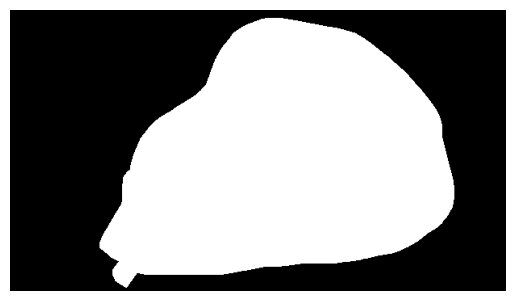

In [21]:
mask = np.load("../data/dataset/masks/0001/granulom.npy")
print(np.unique(mask))
plt.imshow(mask, cmap="gray")
plt.axis("off")
plt.show()

In [44]:
from typing import List, Tuple
import math


def get_images():
    """Get an image from the dataset"""
    response = requests.get(f"http://localhost:5000/images/all/1")
    if response.status_code != 200:
        raise Exception(f"API request failed: {response.text}")
    return response.json()


# Helper function to call the API
def get_mask_matrices(image_id: int):
    """Get mask matrices for an image from the API"""
    response = requests.get(f"http://localhost:5000/masks/matrices/{image_id}")
    if response.status_code != 200:
        raise Exception(f"API request failed: {response.text}")
    return response.json()


# compute optimal stride to cover the entire image
def compute_stride(image_dim: int, patch_dim: int) -> Tuple[int, int]:
    n_patches = math.ceil(image_dim / patch_dim)
    stride = (
        math.floor((image_dim - patch_dim) / (n_patches - 1))
        if n_patches > 1
        else patch_dim
    )
    return stride, n_patches


def pad_to_size(img, target_size=256):
    """Pad the image to the target size."""
    h, w = img.shape[:2]
    c = img.shape[2] if len(img.shape) == 3 else 1
    top = (target_size - h) // 2
    bottom = target_size - h - top
    left = (target_size - w) // 2 if w < target_size else 0
    right = target_size - w - left if w < target_size else 0
    return cv2.copyMakeBorder(
        img,
        top,
        bottom,
        left,
        right,
        cv2.BORDER_CONSTANT,
        value=0 if c == 1 else [0, 0, 0],
    )


def split_image_into_patches(
    image: np.ndarray, patch_size: int = 256
) -> Tuple[
    List[np.ndarray], List[Tuple[int, int]], Tuple[int, int], Tuple[float, float]
]:
    if image.shape[0] < patch_size or image.shape[1] < patch_size:
        image = pad_to_size(image, patch_size)
    image_height, image_width = image.shape[:2]
    stride_x, n_patches_x = compute_stride(image_width, patch_size)
    stride_y, n_patches_y = compute_stride(image_height, patch_size)

    patches = []
    positions = []
    for i in range(0, image_height - patch_size + 1, stride_y):
        for j in range(0, image_width - patch_size + 1, stride_x):
            patch = image[i : i + patch_size, j : j + patch_size]
            patches.append(patch)
            positions.append((i, j))
    return patches, positions, (stride_x, stride_y), (n_patches_x, n_patches_y)


def decode_base64_image(base64_string: str) -> np.ndarray:
    """Convert base64 image string to numpy array."""
    try:
        # Remove the data URL prefix if present
        if "," in base64_string:
            base64_string = base64_string.split(",")[1]

        # Decode base64 to bytes
        image_bytes = base64.b64decode(base64_string)

        # Convert bytes to numpy array
        image_array = np.frombuffer(image_bytes, dtype=np.uint8)

        # Decode image array as color
        image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

        return image
    except Exception as e:
        raise ValueError(f"Error decoding base64 image: {str(e)}")

In [57]:
dataset["image_id"].unique(), images.keys()

(array([ 1, 40, 61,  3,  4,  5,  7, 10,  8,  9, 19, 22, 11, 12, 13, 14, 15,
        16, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 41, 44, 45, 42, 43, 52, 56, 60, 46, 47, 48, 49, 51,
        53, 55, 58, 59]),
 dict_keys(['2', '3', '4', '5', '6', '7', '8', '9', '10', '11']))

In [ ]:
# Get all image IDs from the dataset
image_ids = dataset["image_id"].unique()

# Choose an image_id to process (for example, the first one)
selected_image_id = image_ids[0]

# Filter patches for the selected image_id
patches_df = dataset[dataset["image_id"] == selected_image_id]

positions = []
for i in range(len(patches_df)):
    positions.append((i, i))


patch_size = 256


# Reconstruct the image
reconstructed = reconstruct_image_from_patches(
    patches_df, positions, selected_img.shape, patch_size
)

# Display the reconstructed image
plt.imshow(reconstructed)
plt.title(f"Reconstructed Image (image_id={selected_image_id})")
plt.axis("off")
plt.show()

KeyError: '1'

Selected image ID: 5


(np.float64(-0.5), np.float64(232.5), np.float64(181.5), np.float64(-0.5))

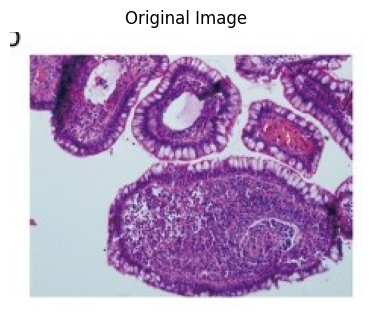

In [33]:
# Set image ID
image_id = 5
image_path = os.path.join("../data/dataset/images/0005.jpg")
print(f"Selected image ID: {image_id}")

# Load and display the original image
image = Image.open(image_path)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

Found 2 masks


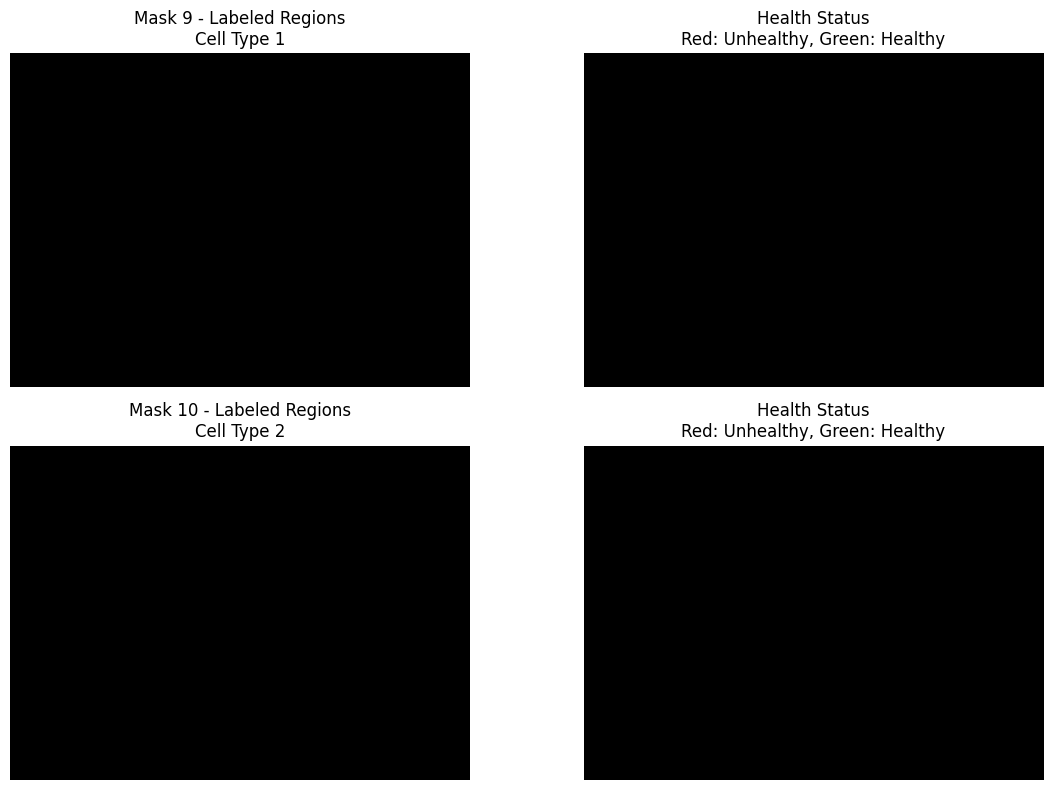

In [34]:
# Get mask matrices from API
try:
    response = get_mask_matrices(image_id)
    masks = response["masks"]

    # Display mask information
    print(f"Found {len(masks)} masks")

    # Create a figure to display all masks
    n_masks = len(masks)
    if n_masks > 0:
        fig, axs = plt.subplots(n_masks, 2, figsize=(12, 4 * n_masks))
        if n_masks == 1:
            axs = [axs]  # Make it iterable when there's only one mask

        for i, mask_data in enumerate(masks):
            # Convert lists to numpy arrays
            labeled_regions = np.array(mask_data["labeledRegions"])
            health_mask = np.array(mask_data["mask"])

            # Display labeled regions
            axs[i][0].imshow(labeled_regions, cmap="nipy_spectral")
            axs[i][0].set_title(
                f'Mask {mask_data["mask_id"]} - Labeled Regions\nCell Type {mask_data["cell_id"]}'
            )
            axs[i][0].axis("off")

            # Display health status
            # Create a custom colormap: black=0 (background), red=1 (unhealthy), green=2 (healthy)
            cmap = plt.cm.colors.ListedColormap(["black", "red", "green"])
            axs[i][1].imshow(health_mask, cmap=cmap, vmin=0, vmax=2)
            axs[i][1].set_title(f"Health Status\nRed: Unhealthy, Green: Healthy")
            axs[i][1].axis("off")

        plt.tight_layout()
    else:
        print("No masks found for this image")

except Exception as e:
    print(f"Error: {str(e)}")